# MLOceanEnsemble with drifters for the Basin


### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "k"
plt.rcParams["text.color"] = "k"
plt.rcParams["axes.labelcolor"] = "k"
plt.rcParams["xtick.color"] = "k"
plt.rcParams["ytick.color"] = "k"

plt.rcParams["image.origin"] = "lower"

from importlib import reload

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common, WindStress, DrifterPlotHelper, Observation
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL
from gpuocean.drifters import MLDrifterCollection, GPUDrifterCollection


In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Basin utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinPlot import * 
from utils.BasinParameters import * 
from utils.BasinEnsembleInit import * 

In [6]:
main_drifter_folder = 'drifter_data'
timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
drifter_folder = os.path.join(main_drifter_folder, 'mldrifters_' + timestamp)
sl_drifter_folder = os.path.join(main_drifter_folder, 'sldrifters_' + timestamp)


## ML ensemble

In [7]:
ls = [6, 7, 8, 9]

In [8]:
args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [9]:
data_args_list = []

for l_idx in range(len(ls)):
    data_args_list.append( make_init_steady_state(args_list[l_idx], a=steady_state_bump_a, bump_fractal_dist=steady_state_bump_fractal_dist) )


In [10]:
for l_idx in range(len(ls)):
    print(data_args_list[l_idx]['eta'][2:-2,2:-2].shape)

(128, 64)
(256, 128)
(512, 256)
(1024, 512)


In [11]:
spinup_end_time = 0
end_time = spinup_end_time + 900*5


In [12]:
#ML_Nes = [100, 75, 50, 25] # From Flo. Takes 1m24s to init, 3m13s to run to T=900
ML_Nes = [30, 20, 15, 10] # init: 34s, run: 1m36s


In [13]:
ML_ensemble = initMLensemble(ML_Nes, args_list, data_args_list, sample_args, 
                             init_model_error_basis_args=init_model_error_basis_args, 
                             sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_time_step=sim_model_error_timestep)

In [14]:
from gpuocean.ensembles import MultiLevelOceanEnsemble

In [15]:
reload(MultiLevelOceanEnsemble)
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

In [16]:
MLOceanEnsemble.stepToObservation(spinup_end_time)

In [17]:
drifter_ensemble_size = 30
num_drifters = 25
MLOceanEnsemble.attachDrifters(drifter_ensemble_size, num_drifters, drift_sensitivity=1)
sl_obs = []
for dsim in MLOceanEnsemble.ML_ensemble[2][0]:
    drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters,
                                                          boundaryConditions=dsim.boundary_conditions,
                                                          domain_size_x=dsim.nx*dsim.dx, 
                                                          domain_size_y=dsim.ny*dsim.dy)
    dsim.attachDrifters(drifters)
    obs = Observation.Observation(nx=dsim.nx, ny=dsim.ny,
                                  domain_size_x=dsim.nx*dsim.dx, 
                                  domain_size_y=dsim.ny*dsim.dy)
    obs.add_observation_from_sim(dsim)
    sl_obs.append(obs)
    
init_positions = MLOceanEnsemble.drifters.getDrifterPositions()
init_pos_6  = MLOceanEnsemble.drifters.getDrifterPositionsForDrifter(6)
init_pos_11 = MLOceanEnsemble.drifters.getDrifterPositionsForDrifter(11)

print(drifter_folder)

drifter_data/mldrifters_2023_09_05-09_55_43


In [18]:
t = spinup_end_time
registration_frequency =  3*60
while t < end_time:
    tmp_end_time = t + registration_frequency
    MLOceanEnsemble.stepToObservation(tmp_end_time)
    MLOceanEnsemble.registerDrifterPositions()
    for sl_e in range(len(MLOceanEnsemble.ML_ensemble[2][0])):
        sl_obs[sl_e].add_observation_from_sim(MLOceanEnsemble.ML_ensemble[2][0][sl_e])

    t = t + registration_frequency


In [19]:
end_positions = MLOceanEnsemble.drifters.getDrifterPositions()
end_pos_6  = MLOceanEnsemble.drifters.getDrifterPositionsForDrifter(6)
end_pos_11 = MLOceanEnsemble.drifters.getDrifterPositionsForDrifter(11)


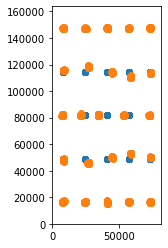

In [20]:

domain_size_x = MLOceanEnsemble.ML_ensemble[0][0].dx*MLOceanEnsemble.ML_ensemble[0][0].nx
domain_size_y = MLOceanEnsemble.ML_ensemble[0][0].dy*MLOceanEnsemble.ML_ensemble[0][0].ny
plt.scatter(init_positions[:, 0], init_positions[:, 1])
plt.xlim(0, domain_size_x)
plt.ylim(0, domain_size_y)
plt.gca().set_aspect('equal')
plt.scatter(end_positions[:, 0], end_positions[:, 1])
            

[[27060.16233172 45369.55937424]
 [27464.52847524 45497.20378463]
 [27555.85849055 45992.54753637]
 [27354.94585495 45532.63177735]
 [26018.0719268  45998.8157285 ]
 [27617.26423598 45530.14915661]
 [27534.86926736 45750.67970308]
 [26844.87113533 46019.56740733]
 [26799.91902505 45805.43353247]
 [27239.85442494 46460.03498412]
 [27124.97664965 45794.45301016]
 [27373.57981312 46263.65827231]
 [26729.51574261 45709.37681904]
 [27399.15707113 45128.89137593]
 [26616.48109036 45959.9632155 ]
 [26827.95210572 46660.95279644]
 [26678.22034081 45912.67613941]
 [27628.20489069 45907.51395785]
 [27247.87643024 46093.49348727]
 [26646.37415059 45396.93468246]
 [26591.10383533 46045.58436078]
 [26875.91399602 45507.23357622]
 [26359.74043988 45725.26479537]
 [27200.18646916 45746.7272685 ]
 [26751.34458461 46008.78954528]
 [26815.15738308 45348.54196267]
 [27796.25219198 45433.18881109]
 [27775.31919494 45684.74449203]
 [27300.89895515 46373.69675793]
 [27241.19185281 45018.89517363]]


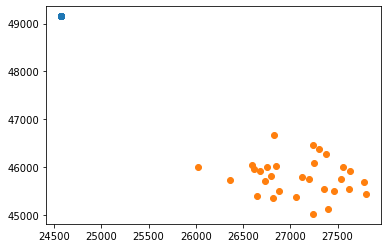

In [21]:

plt.scatter(init_pos_6[:, 0], init_pos_6[:, 1])
plt.scatter(end_pos_6[:, 0], end_pos_6[:, 1])
print(end_pos_6)
            

[[21243.4989625  81761.40237302]
 [21147.87777545 81225.68188461]
 [21764.57875144 81310.04666898]
 [21068.28823926 81034.08424174]
 [21172.99341294 82188.17452772]
 [21210.55999656 82872.22824577]
 [20692.90618164 82147.24531094]
 [21680.305519   80920.65136188]
 [21465.47298141 81930.45047128]
 [20703.13007468 82338.34613038]
 [21436.35042033 81911.38391809]
 [21417.90164153 81827.0588592 ]
 [21893.83397192 81874.22789928]
 [21387.04603518 81645.9210561 ]
 [21444.15003189 82229.7557795 ]
 [21609.56475779 81613.12376629]
 [21453.40975793 82481.83299495]
 [21560.87459098 83355.60654401]
 [21090.7198584  82255.02301927]
 [21246.52651002 82083.06146217]
 [21660.18132776 82000.06037846]
 [21067.86036214 81572.60692332]
 [21257.38613412 81668.52995015]
 [21641.15042521 82072.51752033]
 [21586.11834077 81961.3171277 ]
 [20951.36198329 82043.86181356]
 [21757.7545818  81271.49769228]
 [21562.85339725 81889.53256779]
 [21208.2962205  81261.56176527]
 [21078.92912981 82226.55937632]]


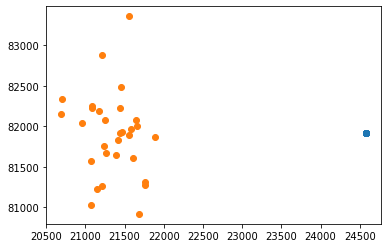

In [22]:

plt.scatter(init_pos_11[:, 0], init_pos_11[:, 1])
plt.scatter(end_pos_11[:, 0], end_pos_11[:, 1])
print(end_pos_11)
            

#### Save drifters to file
One file will contain one realization of every drifter, meaning that the there will be `drifter_ensemble_size` files, each with `num_drifters` drifters.

In [23]:
os.makedirs(drifter_folder)
MLOceanEnsemble.saveDriftTrajectoriesToFile(drifter_folder, "mldrifters")

In [24]:
os.makedirs(sl_drifter_folder)


### Plot the drifters

In [25]:
def readObservationFiles(folder):
    print(folder)
    obs_files = os.listdir(folder)
    print(obs_files)
    obs_files = list(file for file in obs_files if file.startswith("mldrifters"))
    print(obs_files)
    obs_files = list(file for file in obs_files if file.endswith(".bz2"))
    print(obs_files)
    obs_files = list(os.path.join(folder, file)  for file in obs_files)


    # Read observation files from the ensemble:
    assert(len(obs_files) == drifter_ensemble_size)
    ensemble_trajectories = [None]*len(obs_files)
    for i in range(len(obs_files)):
        ensemble_trajectories[i] = Observation.Observation(domain_size_x=domain_size_x, 
                                                        domain_size_y=domain_size_y, 
                                                        nx=MLOceanEnsemble.nxs[-1], ny=MLOceanEnsemble.nys[-1])
        ensemble_trajectories[i].read_pickle(obs_files[i])
        print("."+str(i)+".", end='')
    return ensemble_trajectories

ml_ensemble_trajectories = readObservationFiles(drifter_folder)
#sl_ensemble_trajectories = readObservationFiles(sl_drifter_folder)


drifter_data/mldrifters_2023_09_05-09_55_43
['mldrifters0019.bz2', 'mldrifters0028.bz2', 'mldrifters0008.bz2', 'mldrifters0025.bz2', 'mldrifters0023.bz2', 'mldrifters0017.bz2', 'mldrifters0006.bz2', 'mldrifters0022.bz2', 'mldrifters0027.bz2', 'mldrifters0026.bz2', 'mldrifters0009.bz2', 'mldrifters0029.bz2', 'mldrifters0016.bz2', 'mldrifters0020.bz2', 'mldrifters0001.bz2', 'mldrifters0010.bz2', 'mldrifters0002.bz2', 'mldrifters0024.bz2', 'mldrifters0007.bz2', 'mldrifters0018.bz2', 'mldrifters0014.bz2', 'mldrifters0021.bz2', 'mldrifters0012.bz2', 'mldrifters0011.bz2', 'mldrifters0000.bz2', 'mldrifters0003.bz2', 'mldrifters0013.bz2', 'mldrifters0004.bz2', 'mldrifters0005.bz2', 'mldrifters0015.bz2']
['mldrifters0019.bz2', 'mldrifters0028.bz2', 'mldrifters0008.bz2', 'mldrifters0025.bz2', 'mldrifters0023.bz2', 'mldrifters0017.bz2', 'mldrifters0006.bz2', 'mldrifters0022.bz2', 'mldrifters0027.bz2', 'mldrifters0026.bz2', 'mldrifters0009.bz2', 'mldrifters0029.bz2', 'mldrifters0016.bz2', 'mldrift

#### Plot all drifters from the first (drifter) ensemble member

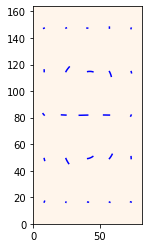

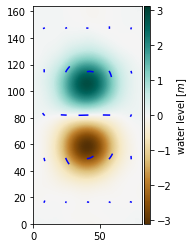

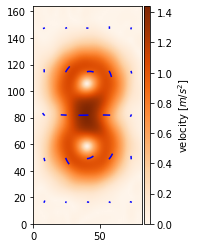

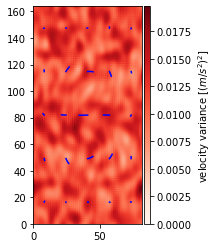

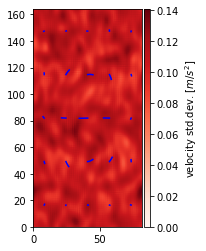

In [26]:
reload(DrifterPlotHelper)
for background in ["landmask", "eta", "velocity", "velocity_variance", "velocity_stddev"]:
    ax = DrifterPlotHelper.background_from_mlensemble(MLOceanEnsemble, background_type=background)
    for i in range(num_drifters):
        DrifterPlotHelper.add_drifter_on_background(ax, ml_ensemble_trajectories[0], drifter_id=i)


#### Plot all realizations of a given drifter

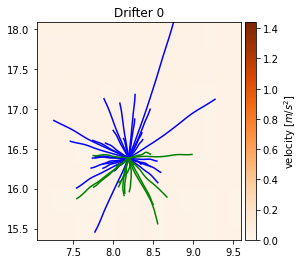

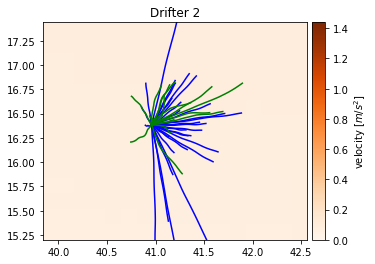

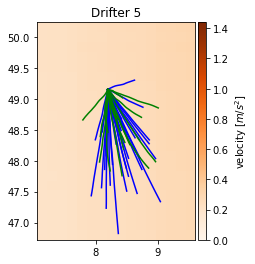

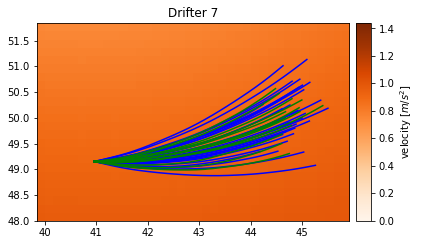

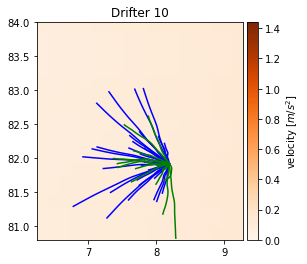

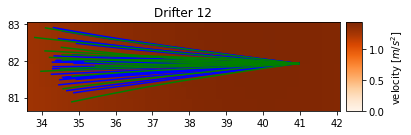

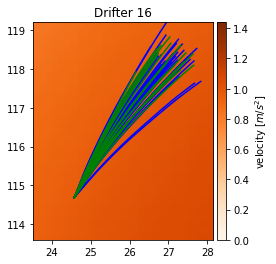

In [27]:
for drifter_id in [0, 2, 5, 7, 10, 12, 16]:
    drifter_domain = DrifterPlotHelper.domain_around_drifter(ml_ensemble_trajectories[0], drifter_id=drifter_id, padding_in_km=1)
    ax = DrifterPlotHelper.background_from_mlensemble(MLOceanEnsemble, background_type="velocity", drifter_domain=drifter_domain)
    ax.set_title("Drifter "+str(drifter_id))
    DrifterPlotHelper.add_ensemble_drifter_on_background(ax, ml_ensemble_trajectories, drifter_id=drifter_id)
    DrifterPlotHelper.add_ensemble_drifter_on_background(ax, sl_obs, drifter_id=drifter_id, color='Green')
    

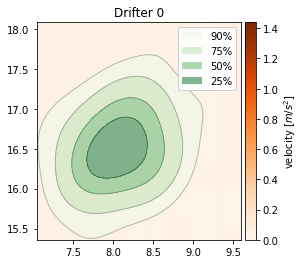

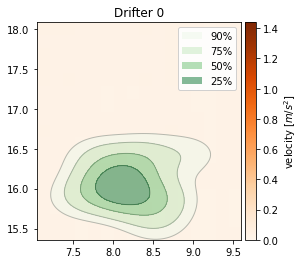

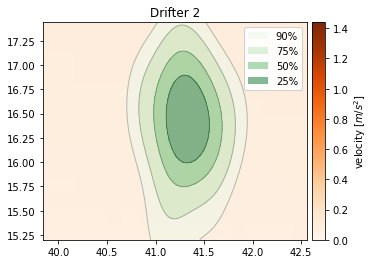

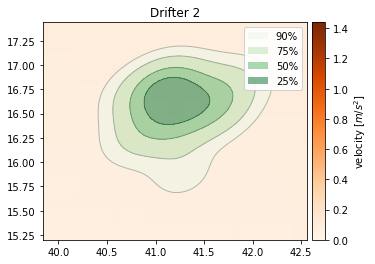

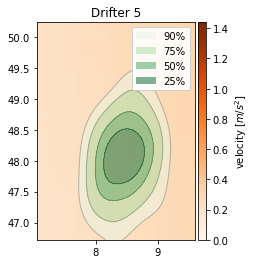

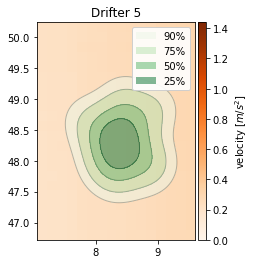

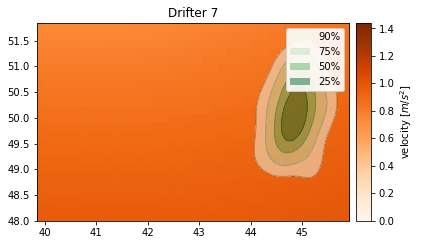

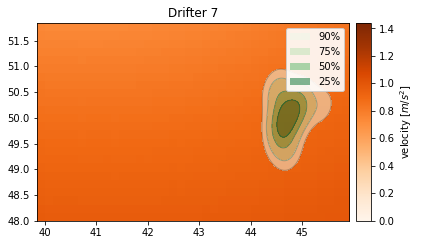

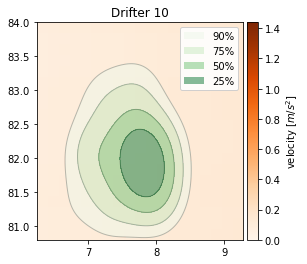

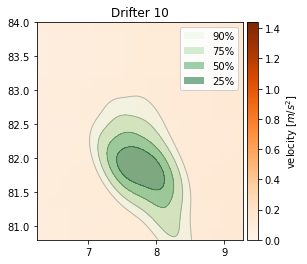

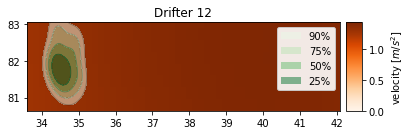

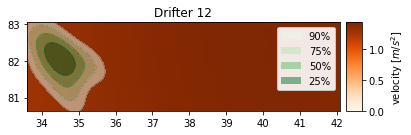

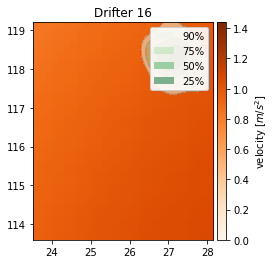

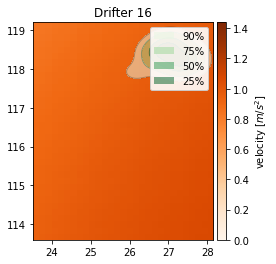

In [28]:
for drifter_id in [0, 2, 5, 7, 10, 12, 16]:
    drifter_domain = DrifterPlotHelper.domain_around_drifter(ml_ensemble_trajectories[0], drifter_id=drifter_id, padding_in_km=1)
    ax = DrifterPlotHelper.background_from_mlensemble(MLOceanEnsemble, background_type="velocity", drifter_domain=drifter_domain)
    ax.set_title("Drifter "+str(drifter_id))
    DrifterPlotHelper.add_kde_on_background(ax, ml_ensemble_trajectories, drifter_id=drifter_id)

    ax = DrifterPlotHelper.background_from_mlensemble(MLOceanEnsemble, background_type="velocity", drifter_domain=drifter_domain)
    ax.set_title("Drifter "+str(drifter_id))
    DrifterPlotHelper.add_kde_on_background(ax, sl_obs, drifter_id=drifter_id, color='Green')
    